\begin{equation*}
\left\{
\begin{array}{ll}
    u_{xx} + (a + x)u_x + b x u(x) = f(x), & 0 \leq x \leq 1, \\[10pt]
    u(0) = \alpha, \\[10pt]
    u(1) = \beta.
\end{array}
\right.
\end{equation*}
Analytical Solution:
\begin{equation}
u(x) = \sin(\pi x)
\end{equation}


In [ ]:
import numpy as np
from sklearn.linear_model import Lasso
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
nx = 100
x = np.linspace(0, 1, nx)
u = np.sin(np.pi * x)


dx = x[1] - x[0]
u_x = np.zeros_like(u)
u_xx = np.zeros_like(u)

u_x[1:-1] = (u[2:] - u[:-2]) / (2 * dx)
u_xx[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / (dx**2)

In [ ]:
Theta = np.stack([
    u_x,
    x*u_x,
    x*u
], axis=1)

f = u_xx + x*u_x


Y = -f[1:-1]
X_reg = np.stack([u_x[1:-1], x[1:-1]*u[1:-1]], axis=1)

lasso = Lasso(alpha=1e-8)
lasso.fit(X_reg, Y)
a_est, b_est = lasso.coef_

print(f"Estimated a: {a_est:.5f}")
print(f"Estimated b: {b_est:.5f}")

print("\nIdentified ODE:")
print(f"u_xx + ({a_est:+.5f} + x)u_x + ({b_est:+.5f}) x u = f(x)")


Estimated a: 0.23866
Estimated b: 14.28850

Identified ODE:
u_xx + (+0.23866 + x)u_x + (+14.28850) x u = f(x)


epoch     0   loss = 6.5020e+00
epoch   500   loss = 1.3026e+00
epoch  1000   loss = 8.6360e-02
epoch  1500   loss = 2.8460e-02
epoch  2000   loss = 2.5537e-02
epoch  2500   loss = 2.4219e-02
epoch  3000   loss = 2.2926e-02
epoch  3500   loss = 2.1178e-02
epoch  4000   loss = 1.4821e-02
epoch  4500   loss = 1.0342e-02
epoch  5000   loss = 4.7009e-03
epoch  5500   loss = 2.1682e-03
epoch  6000   loss = 7.1779e-04
epoch  6500   loss = 2.3658e-04
epoch  7000   loss = 1.6728e-04
epoch  7500   loss = 1.2802e-04
epoch  8000   loss = 1.1748e-04
epoch  8500   loss = 8.7921e-03
epoch  9000   loss = 8.5613e-05
epoch  9500   loss = 1.0645e-04
epoch 10000   loss = 6.7400e-05


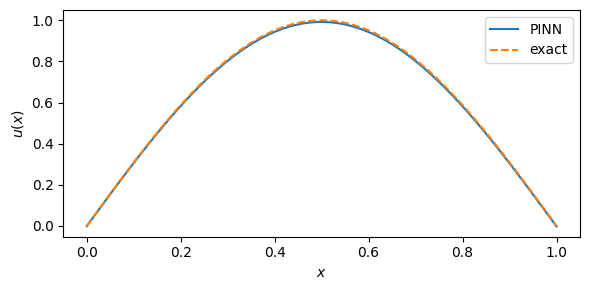

In [ ]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

a = 0.23866
b = 14.28850
π = np.pi

x_left, x_right = 0.0, 1.0
lb = tf.constant([x_left], DTYPE)
ub = tf.constant([x_right], DTYPE)

def u_exact(x):
    return tf.sin(np.pi * x)

def f_fun(x):
    return (-π**2 * tf.sin(π*x)
            + (a + x) * π * tf.cos(π*x)
            + b * x * tf.sin(π*x))

N_b = 100
N_r = 1000

X_b = tf.constant([[x_left],[x_right]], DTYPE)
u_b = tf.constant([[0.],[0.]], DTYPE)   # α = β = 0

X_r = tf.random.uniform((N_r,1), x_left, x_right, DTYPE)
f_r = f_fun(X_r)

class PINN(tf.keras.Model):
    def __init__(self, layers, lb, ub):
        super().__init__()
        self.lb, self.ub = lb, ub
        self.hidden = [tf.keras.layers.Dense(w, activation='tanh') for w in layers[:-1]]
        self.out = tf.keras.layers.Dense(layers[-1])

    def call(self, X):
        # scale to [-1,1]
        Z = 2.*(X - self.lb)/(self.ub - self.lb) - 1.
        for lyr in self.hidden:
            Z = lyr(Z)
        return self.out(Z)

def pde_residual(model, X):
    x = X[:, :1]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        u = model(x)
        u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
    del tape
    f = f_fun(x)
    return u_xx + (a + x)*u_x + b*x*u - f

def loss_fn(model):
    r = pde_residual(model, X_r)
    loss_r = tf.reduce_mean(tf.square(r))
    u_b_pred = model(X_b)
    loss_b = tf.reduce_mean(tf.square(u_b_pred - u_b))
    return loss_r + loss_b

@tf.function
def train_step(model, opt):
    with tf.GradientTape() as tape:
        loss = loss_fn(model)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

layers = [1, 64, 64, 64, 1]
model = PINN(layers, lb, ub)

opt = tf.keras.optimizers.Adam(learning_rate=8e-4)
epochs = 10000
for ep in range(epochs+1):
    l = train_step(model, opt)
    if ep % 500 == 0:
        print(f"epoch {ep:5d}   loss = {l.numpy():.4e}")

x_plot = np.linspace(x_left, x_right, 300, DTYPE)[:,None]
u_pred = model(x_plot).numpy()
u_ex = u_exact(x_plot).numpy()

plt.figure(figsize=(6,3))
plt.plot(x_plot, u_pred, label='PINN')
plt.plot(x_plot, u_ex, '--', label='exact')
plt.xlabel('$x$'); plt.ylabel('$u(x)$')
plt.legend(); plt.tight_layout(); plt.show()
